## Train an embedding neural network to discern 'contentious patients' from those with high agreement to thrombolyse

In this notebook we use a pre-trained model (embedding neural network with 1D embedding, use to test a 10k cohort of patients) to predict thrombolysis use of all patients at all hospitals. Patients are then split into three groups:

* *Agree not to thrombolyse*: Few than 25% of hospitals would give thrombolysis
* *Contentious*: 25% to 75% would give thrombolysis
* *Agree to thrombolyse*: More than 75% of hospitals would give thrombolysis

We then train an embedding neural network model (using patient and pwathway data subsets) to distinguisg between *Contentious* and *Agree to thrombolyse*. This is saved for more detailed analysis in a subsequent notebook.

## Load libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

clear_output()

## Define function to scale data

Scale input data 0-1 (MinMax scaling).

In [2]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

## Predict thrombolysis decision for 10K cohort

In [3]:
# Load model
path = './saved_models/1d_for_10k/'
filename = f'{path}model.h5'
model = keras.models.load_model(filename)

# Clear TensorFlow output from cell
clear_output()

In [4]:
# Load data
train = pd.read_csv(f'../../data/sam_1/10k_training_test/cohort_10000_train.csv')
test = pd.read_csv(f'../../data/sam_1/10k_training_test/cohort_10000_test.csv')

# Get data subgroups
subgroups = pd.read_csv('../../data/sam_1/subnet.csv', index_col='Item')
# Get list of clinical items
clinical_subgroup = subgroups.loc[subgroups['Subnet']=='clinical']
clinical_subgroup = list(clinical_subgroup.index)
# Get list of pathway items
pathway_subgroup = subgroups.loc[subgroups['Subnet']=='pathway']
pathway_subgroup = list(pathway_subgroup.index)
# Get list of hospital items
hospital_subgroup = subgroups.loc[subgroups['Subnet']=='hospital']
hospital_subgroup = list(hospital_subgroup.index)

# OneHot encode stroke team
coded = pd.get_dummies(train['StrokeTeam'])
train = pd.concat([train, coded], axis=1)
train.drop('StrokeTeam', inplace=True, axis=1)
coded = pd.get_dummies(test['StrokeTeam'])
test = pd.concat([test, coded], axis=1)
test.drop('StrokeTeam', inplace=True, axis=1)

# Split into X, y
X_train_df = train.drop('S2Thrombolysis',axis=1) 
y_train_df = train['S2Thrombolysis']
X_test_df = test.drop('S2Thrombolysis',axis=1) 
y_test_df = test['S2Thrombolysis'] 

# Split train and test data by subgroups
X_train_patients = X_train_df[clinical_subgroup]
X_test_patients = X_test_df[clinical_subgroup]
X_train_pathway = X_train_df[pathway_subgroup]
X_test_pathway = X_test_df[pathway_subgroup]
X_train_hospitals = X_train_df[hospital_subgroup]
X_test_hospitals = X_test_df[hospital_subgroup]

# Convert to NumPy (Train is not used here; retained in case we want to use train later)
X_train = X_train_df.values # Not used here
X_test = X_test_df.values
y_train = y_train_df.values # Not used here
y_test = y_test_df.values

# Scale data
X_train_patients_sc, X_test_patients_sc = \
    scale_data(X_train_patients, X_test_patients)

X_train_pathway_sc, X_test_pathway_sc = \
    scale_data(X_train_pathway, X_test_pathway)

X_train_hospitals_sc, X_test_hospitals_sc = \
    scale_data(X_train_hospitals, X_test_hospitals)

# Test model
probability = model.predict(
    [X_test_patients_sc, X_test_pathway_sc, X_test_hospitals_sc])

y_pred_test = probability >= 0.5
y_pred_test = y_pred_test.flatten()
accuracy_test = np.mean(y_pred_test == y_test)

# Clear TensorFlow output from cell and display accuracy
clear_output()
print(f'Accuracy test {accuracy_test:0.3f}')

Accuracy test 0.849


## Get predictions for thrombolysis use of all patients at each hospital

Here we ask the counter-factual question - "what treatment would a patient be expected to receive at each of the 132 hospitals?".

Hospital is one-hot encoded as input to the hospital subnet. To make a prediction of treatment at different hospitals we change the one-hot encoding of the hospital when making prediction.

For each hospital we pass all patients, and record the proportion of the patients receiving thrombolysis at that hospital.

In [5]:
# Combine train and test sets
X_comb_patients_sc = np.concatenate(
    [X_train_patients_sc, X_test_patients_sc], axis=0)
X_comb_hospitals_sc = np.concatenate(
    [X_train_hospitals_sc, X_test_hospitals_sc], axis=0)
X_comb_pathway_sc = np.concatenate(
    [X_train_pathway_sc, X_test_pathway_sc], axis=0)

# Get number of hospitals
num_hospitals = len(X_comb_hospitals_sc[0])
# Create test array for changing hospital ID
X_hospitals_alter = X_comb_hospitals_sc.copy()
# Get classification for all patients at all hospials
patient_results = []

# Loop through setting hospital
hospital_results = []
for hosp in range(num_hospitals):
    clear_output()
    print(f'{hosp+1} out of {num_hospitals}')
    # Set all hospitals to zero
    X_hospitals_alter[:,:] = 0
    # Set test hospital to 1
    X_hospitals_alter[:,hosp] = 1
    # Get probability of thrombolysis
    probability = model.predict(
        [X_comb_patients_sc, X_comb_pathway_sc, X_hospitals_alter])
    # Classify
    classified = probability >= 0.5
    patient_results.append(classified)
    # Get average thrombolysis
    thrombolysis = classified.mean()
    hospital_results.append(thrombolysis)

132 out of 132


In [6]:
# Store in dataframe
patient_results_array = np.array(patient_results)[:,:,0].T
patient_results_df = pd.DataFrame(
    patient_results_array,columns=list(X_comb_hospitals_sc))
# Save
patient_results_df.to_csv('./output/all_patient_all_hosp_predictions.csv')

### Show split bettwern different groups

In [7]:
# Summarise results
patient_summary = pd.DataFrame()
# Get of hospitals giving thrombolysis to each patient
num_hospitals_thrombolysing = patient_results_df.sum(axis=1)
patient_summary['num_hospitals_thrombolysing'] = num_hospitals_thrombolysing
# Get limits for 25% and 75% hospitals
lower_limit = np.round(num_hospitals) * 0.25
upper_limit = np.round(num_hospitals) * 0.75
# Get high agreement patients
agree_no_thrombolysis = num_hospitals_thrombolysing < lower_limit
agree_give_thrombolysis = num_hospitals_thrombolysing > upper_limit
# Get contentious patients
contentious_patients = ((num_hospitals_thrombolysing >= lower_limit) & 
                        (num_hospitals_thrombolysing <= upper_limit))
# Record in data frame
patient_summary['agree_no_thrombolysis'] = agree_no_thrombolysis
patient_summary['agree_give_thrombolysis'] = agree_give_thrombolysis
patient_summary['contentious_patients'] = contentious_patients

# Show means
patient_summary.mean(axis=0)

num_hospitals_thrombolysing    38.252643
agree_no_thrombolysis           0.658814
agree_give_thrombolysis         0.241904
contentious_patients            0.099283
dtype: float64

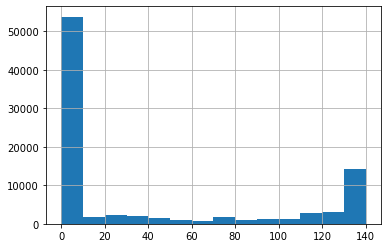

In [8]:
# Show count of number of hospitals who would give thrombolysis
num_hospitals_thrombolysing.hist(bins=np.arange(0, num_hospitals+10, 10));

### Remove patients where there high agreement not to thrombolyse and save data

We will then compare contentious vs. agree to thrombolyse

In [9]:
X_comb = pd.concat([X_train_df, X_test_df], axis=0)
mask = agree_no_thrombolysis == False
X_comb_patients_sc_thromb = X_comb_patients_sc[mask]
X_comb_pathway_sc_thromb = X_comb_pathway_sc[mask]
num_hospitals_thrombolysing_thromb = num_hospitals_thrombolysing[mask]
X_comb_thromb = X_comb[mask.values]

# Label contentious patients
y_contentious = num_hospitals_thrombolysing_thromb <= upper_limit
# Show proportion contentiosu patients (out of contentious or agree to thrombolyse)
print(f'{y_contentious.mean():0.3f}')

# Save contentious patients
save_path = '../../data/sam_1/contentious_patients/'

X_comb_thromb.to_csv(f'{save_path}X_contentious.csv', index=False)
np.savetxt(f'{save_path}X_contentious_patients_sc.csv', 
           X_comb_patients_sc_thromb, delimiter=',')
np.savetxt(f'{save_path}X_comb_pathway_sc_thromb.csv',
           X_comb_pathway_sc_thromb, delimiter=',')
np.savetxt(f'{save_path}num_hosp_thrombolysing.csv',
           num_hospitals_thrombolysing_thromb, delimiter=',')
np.savetxt(f'{save_path}contentious_y_label.csv',
           y_contentious, delimiter=',')

0.291


## Fit model to predict contentious patients (vs. agree to thrombolyse)

### Split data

Use NumPy binomial to be able to use a mask for different X components.
Stata has already been scaled.

In [10]:
# Create masks for train and test
number_patients = len(X_comb_thromb)
number_in_test = int(number_patients * 0.2)
number_in_train = number_patients - number_in_test

np.random.state = 42
mask = np.concatenate(
    [np.ones(number_in_test), np.zeros(number_in_train)], axis=0)
np.random.shuffle(mask)
mask_train = mask == 0
mask_test = mask == 1

# Apply mask
X_train_patients = X_comb_patients_sc_thromb[mask_train]
X_test_patients = X_comb_patients_sc_thromb[mask_test]
X_train_pathway = X_comb_pathway_sc_thromb[mask_train]
X_test_pathway = X_comb_pathway_sc_thromb[mask_test]
y_train = y_contentious[mask_train]
y_test = y_contentious[mask_test]

### Define neural net

Uses patient and pathway data, not hospital ID

In [11]:
def make_net(number_features_patient,
             number_features_pathway,
             patient_encoding_neurones=1,
             pathway_encoding_neurones=1,
              expansion=2, 
             learning_rate=0.003, 
             dropout=0.5):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Patient (clinical data) encoding layers
    input_patient = layers.Input(shape=number_features_patient)
    
    # Patient dense layer 1
    patient_dense_1 = layers.Dense(
        number_features_patient * expansion, activation='relu')(input_patient)
    patient_norm_1 = layers.BatchNormalization()(patient_dense_1)
    patient_dropout_1 = layers.Dropout(dropout)(patient_norm_1)
    
    # Patient encoding layer
    patient_encoding = layers.Dense(
        patient_encoding_neurones, activation='sigmoid', 
        name='patient_encode')(patient_dropout_1)    
    
    # Pathway encoding layers
    input_pathway = layers.Input(shape=number_features_pathway)
    
    # pathway dense layer 1
    pathway_dense_1 = layers.Dense(
        number_features_pathway * expansion, activation='relu')(input_pathway)
    pathway_norm_1 = layers.BatchNormalization()(pathway_dense_1)
    pathway_dropout_1 = layers.Dropout(dropout)(pathway_norm_1)
    
    # pathway encoding layer
    pathway_encoding = layers.Dense(
        pathway_encoding_neurones, activation='sigmoid', 
        name='pathway_encode')(pathway_dropout_1)    
 
    # Concatenation layer
    concat = layers.Concatenate()(
        [patient_encoding, pathway_encoding])
    
    # Outpout (single sigmoid)
    outputs = layers.Dense(1, activation='sigmoid')(concat)
    
    # Build net
    net = Model(inputs=[
        input_patient, input_pathway], outputs=outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net

### Fit model

Accuracy train 0.956 Accuracy test 0.947


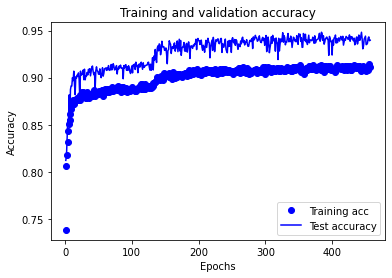

In [12]:
# Define network
number_features_patient = X_train_patients_sc.shape[1]
number_features_pathway = X_train_pathway_sc.shape[1]

model = make_net(
    number_features_patient, 
    number_features_pathway)

# Define save checkpoint callback (only save if new best validation results)
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    'model_checkpoint_1d.h5', save_best_only=True)

# Define early stopping callback: Stop when no validation improvement
# Restore weights to best validation accuracy
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=100, restore_best_weights=True)

# Train model (including class weights)
history = model.fit(
    [X_train_patients, X_train_pathway],
    y_train,
    epochs=10000,
    batch_size=32,
    validation_data=(
        [X_test_patients, X_test_pathway], 
        y_test),
    verbose=0,
    callbacks=[checkpoint_cb, early_stopping_cb])

### Test model
probability = model.predict(
    [X_train_patients, X_train_pathway])
y_pred_train = probability >= 0.5
y_pred_train = y_pred_train.flatten()
accuracy_train = np.mean(y_pred_train == y_train)
print(f'Accuracy train {accuracy_train:0.3f}', end=' ')

probability = model.predict(
    [X_test_patients, X_test_pathway])
y_pred_test = probability >= 0.5
y_pred_test = y_pred_test.flatten()
accuracy_test = np.mean(y_pred_test == y_test)
print(f'Accuracy test {accuracy_test:0.3f}')

# save model
path = './saved_models/contentious_patient/'
filename = f'{path}contentious_patient_model.h5'
model.save(filename);

# Plot training accuracy
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Test performance with Receiver Operator Characteristic Curve

In [13]:
# Get fpr, tpr and thresholds foir each k-fold from scikit-learn's ROC method
fpr, tpr, thresholds = roc_curve(y_test, probability)
# Use scikit-learn's method for calulcating auc
roc_auc = auc(fpr, tpr)
# Print auc result
print (f'AUC {roc_auc:0.4f}')

AUC 0.9886


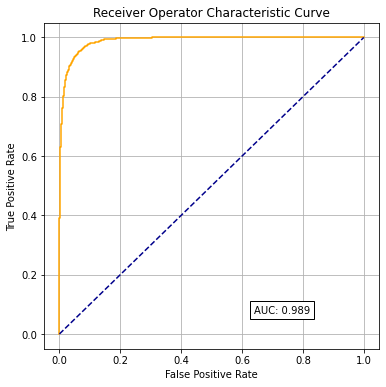

In [14]:
fig = plt.figure(figsize=(6,6))

# Plot ROC
ax1 = fig.add_subplot()
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)
plt.show()